### Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.integrate import odeint
import pysindy as ps
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import complex_ode
a = np.loadtxt('./a.dat')
print(a.shape)
t = a[:, 0]
r = 9
dt = t[1] - t[0]
if r == 3:
    a_temp = a[:, 1:r]
    a_temp = np.hstack((a_temp, a[:, 9].reshape(len(t), 1)))
    a = a_temp
else:
    a = a[:, 1:r+1]
a_max = max(a[:, :2].flatten())

(3000, 10)


In [2]:
def pg_model(a, L, Q):
    """RHS of POD-Galerkin model, for time integration"""
    return (L @ a) + np.einsum('ijk,j,k->i', Q, a, a)

galerkin3 = sio.loadmat('models/galerkin3.mat')
model3 = lambda a, t: pg_model(a, galerkin3['L'], galerkin3['Q'])

galerkin9 = sio.loadmat('models/galerkin9.mat')
gQ = 0.5 * (galerkin9['Q'] + np.transpose(galerkin9['Q'], [0, 2, 1]))
galerkin9['Q'] = gQ - (gQ + np.transpose(gQ, [1, 0, 2]) + np.transpose(gQ, [2, 1, 0]) + np.transpose(gQ, [0, 2, 1]) + np.transpose(gQ, [2, 0, 1]) + np.transpose(gQ, [1, 2, 0])) / 6.0
print(galerkin9['Q'] + np.transpose(galerkin9['Q'], [1, 0, 2]) + np.transpose(galerkin9['Q'], [2, 1, 0]))
print(galerkin9['Q'])
model9 = lambda a, t: pg_model(a, galerkin9['L'], galerkin9['Q'])

# Simulate Galerkin models
t_sim = np.arange(0, 500, dt)

# Generate initial condition from unstable eigenvectors
lamb, Phi = np.linalg.eig(galerkin9['L'])
idx = np.argsort(-np.real(lamb))
lamb, Phi = lamb[idx], Phi[:, idx]
a0 = np.real( 1e-3*Phi[:, :2] @ np.random.random((2)) )

a_galerkin3 = odeint(model3, a0[:3], t_sim)
a_galerkin9 = odeint(model9, a0[:9], t_sim)

[[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00  5.42101086e-20  0.00000000e+00
    0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.73472348e-18
   -5.42101086e-20  2.03287907e-20  0.00000000e+00  0.00000000e+00
   -2.38524478e-18]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   -1.73472348e-18 -6.93889390e-18  0.00000000e+00  0.00000000e+00
    0.00000000e+00]
  [ 0.00000000e+00 -8.67361738e-19  0.00000000e+00  0.00000000e+00
    6.93889390e-18 -1.73472348e-18  0.00000000e+00  2.71050543e-20
    1.86347248e-20]
  [ 0.00000000e+00  0.00000000e+00 -3.46944695e-18  1.38777878e-17
    0.00000000e+00  2.16840434e-19  0.00000000e+00  0.00000000e+00
   -1.08420217e-19]
  [ 0.00000000e+00  2.71050543e-20  0.00000000e+00 -3.46944695e-18
    0.00000000e+00  0.00000000e+00 -3.46944695e-18  0.00000000e+00
    0.00000000e+00]
  [ 5.42101086e-20  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.000

In [3]:
## Setup hyperparameters and matrices
Nr = int((r**2 + 3*r)/2.0)
q = 0
constraint_zeros = np.zeros((r + r*(r-1) + int(r*(r-1)*(r-2)/6.0)))
constraint_matrix = np.zeros((r + r*(r-1) + int(r*(r-1)*(r-2)/6.0), r * Nr))

# Set coefficients adorning terms like a_i^3 to zero
for i in range(r):
    constraint_matrix[q, r*(int((r**2+3*r)/2.0)-r) + i*(r+1)] = 1.0
    q = q + 1

# Set coefficients adorning terms like a_ia_j^2 to be antisymmetric
for i in range(r):
    for j in range(i+1, r):
        constraint_matrix[q, r*(int((r**2+3*r)/2.0)-r+j)+i] = 1.0
        constraint_matrix[q, r*(r+j-1)+j+r*int(i*(2*r-i-3)/2.0)] = 1.0
        q = q + 1
for i in range(r):
     for j in range(0, i):
        constraint_matrix[q, r*(int((r**2+3*r)/2.0)-r+j)+i] = 1.0
        constraint_matrix[q, r*(r+i-1)+j+r*int(j*(2*r-j-3)/2.0)] = 1.0
        q = q + 1

# Set coefficients adorning terms like a_ia_ja_k to be antisymmetric
for i in range(r):
    for j in range(i+1, r):
        for k in range(j+1, r):
            constraint_matrix[q, r*(r+k-1)+i+r*int(j*(2*r-j-3)/2.0)] = 1.0
            constraint_matrix[q, r*(r+k-1)+j+r*int(i*(2*r-i-3)/2.0)] = 1.0
            constraint_matrix[q, r*(r+j-1)+k+r*int(i*(2*r-i-3)/2.0)] = 1.0
            q = q + 1
# delta_{il}delta_{jk}
PL_tensor = np.zeros((r, r, r, Nr))
for i in range(r):
    for j in range(r):
        for k in range(r):
            for l in range(Nr):
                if i == l and j == k:
                    PL_tensor[i, j, k, l] = 1.0

# Now symmetrize PL
for i in range(r):
    for j in range(Nr):
        PL_tensor[:, :, i, j] = 0.5 * (PL_tensor[:, :, i, j] + PL_tensor[:, :, i, j].T)

PQ_tensor= np.zeros((r, r, Nr))
for i in range(r):
    # Off diagonal terms
    for j in range(i+1, r):
        PQ_tensor[i, j, int((i+1)/2.0*(2*r-i)) + j - 1 - i] = 1.0

    # diagonal terms
    PQ_tensor[i, i, Nr - r + i] = 1.0

# Now symmetrize PQ
for j in range(Nr):
    PQ_tensor[:, :, j] = 0.5 * (PQ_tensor[:, :, j] + PQ_tensor[:, :, j].T)
    
library_functions = [lambda x:x, lambda x, y:x*y, lambda x:x**2]  #, lambda ignored: 1]
library_function_names = [lambda x:x, lambda x, y:x+y, lambda x:x+x]  #, lambda ignored: 1]
sindy_library = ps.CustomLibrary(library_functions=library_functions,
                                 function_names=library_function_names)

In [4]:
# Put in initial guess that is the true solution
initial_guess = np.zeros((r, Nr))
gQ = 0.5 * (galerkin9['Q'] + np.transpose(galerkin9['Q'], [0, 2, 1]))
PQ_inv = np.linalg.pinv(PQ_tensor.reshape(r * r, Nr)).reshape(Nr, r, r)
#initial_guess[:, :] = np.tensordot(PQ_inv, gQ, axes=([1, 2], [0, 1])).T
for i in range(r):
    for j in range(i + 1, r):
        initial_guess[:, int((i+1)/2.0*(2*r-i)) + j - 1 - i] = 2.0 * gQ[:, i, j]
    initial_guess[:, Nr - r + i] = gQ[:, i, i]
initial_guess[:, :r] = galerkin9['L']
print(initial_guess[:, :r])
print(galerkin9['L'])

[[ 4.93419393e-02 -9.68392667e-01 -2.13323580e-03  5.84378874e-03
   2.06707276e-02 -5.24958149e-03 -4.22042924e-04 -2.08803313e-03
  -4.33119204e-05]
 [ 9.42838148e-01  3.82057363e-02 -4.62201338e-03 -2.09199761e-03
   2.14748823e-02 -1.77991929e-02 -4.03097041e-04  9.75531245e-04
   2.09917903e-05]
 [ 9.24439206e-04  4.44590461e-03 -1.67917558e-02  1.44024326e+00
  -4.62026113e-03 -6.81444699e-02 -1.25810160e-02 -4.87334671e-02
  -9.87159260e-03]
 [-5.70844886e-03  2.09538891e-03 -1.43385772e+00 -1.62385894e-02
  -5.45455254e-02  8.07711248e-03 -3.58315319e-02  1.65776471e-02
   1.51824911e-02]
 [-2.95338708e-03 -8.47503420e-03  7.98313090e-03  5.45801976e-02
  -6.30381560e-02  1.81478847e+00  3.41568338e-04  1.72734042e-02
  -4.41245069e-04]
 [-6.93725500e-04  7.58053514e-04  6.80050550e-02 -8.15743524e-03
  -1.81070102e+00 -6.30283521e-02 -1.31617849e-02 -2.52153943e-05
  -1.81655042e-05]
 [ 1.71720202e-04  6.93058447e-04  4.82417453e-03  1.89435657e-03
   1.18106558e-03  1.3268586

4.788690334414556 0.0 0.0
4.788690334414556 5.701761432638496e-23 0.0
[ 6.37925114e-03  1.41246273e-03  2.50558358e-01  1.35463062e-01
  6.97684797e-03 -1.41479578e-03  1.30107253e-01  2.14033277e-01
  5.03229748e+00] 10000
4.788690334414556 3.562519009332591e-24 0.0
x0' = 0.04934194 x0 + -0.96839267 x1 + -0.00213324 x2 + 0.00584379 x3 + 0.02067073 x4 + -0.00524958 x5 + -0.00042204 x6 + -0.00208803 x7 + -0.00004331 x8 + -0.00005707 x0x1 + -0.00855294 x0x2 + 0.01416516 x0x3 + -0.00032213 x0x4 + -0.00043644 x0x5 + 0.00010115 x0x6 + -0.00011388 x0x7 + -0.01573874 x0x8 + 0.01005060 x1x2 + 0.00907859 x1x3 + -0.00028853 x1x4 + -0.00035849 x1x5 + -0.00109624 x1x6 + 0.00023285 x1x7 + -0.07803490 x1x8 + 0.00297670 x2x3 + -0.03360562 x2x4 + 0.08507621 x2x5 + -0.00023046 x2x6 + 0.00071545 x2x7 + -0.00005586 x2x8 + -0.08403783 x3x4 + -0.03365015 x3x5 + -0.00053094 x3x6 + -0.00009367 x3x7 + 0.00098053 x3x8 + 0.00352240 x4x5 + 0.00143365 x4x6 + -0.02214815 x4x7 + -0.00097557 x4x8 + -0.02286747 x5x6 

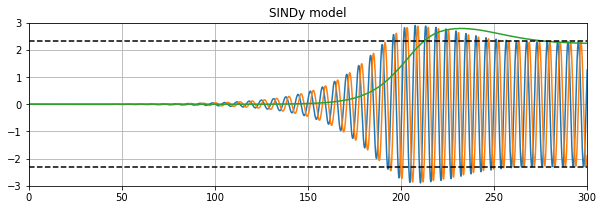

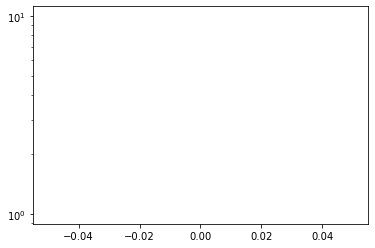

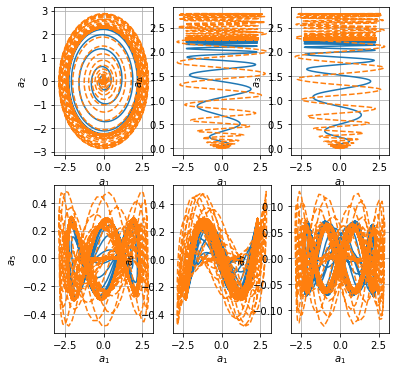

In [5]:
eta = 1e9
threshold = 0.0
gamma = 1e-2 * eta
beta = 0.5 * eta
sindy_opt = ps.clSR3(threshold=threshold, eta=eta, alpha_m=gamma, alpha_A=beta, vtol=1e-6, w_evo=False,
                            PL=PL_tensor, PQ=PQ_tensor, max_iter=50, tol=1e-10, accel=True,
                            thresholder="l1", eigmin=-1e20, eigmax=-0.01, 
                            constraint_lhs=np.zeros(constraint_matrix.shape), #constraint_matrix,
                            constraint_rhs=constraint_zeros,
                            constraint_order="feature",
                            initial_guess=initial_guess)
model = ps.SINDy(
            optimizer=sindy_opt,
            feature_library=sindy_library,
            differentiation_method=ps.FiniteDifference(drop_endpoints=True))
model.fit(a[:, :r], t=t)
model.print(precision=8)
Xi = model.coefficients().T
# Xi = initial_guess.T

# Check if identified model is stable
opt_m = sindy_opt.m_history_[-1]
mPQ = np.zeros(PL_tensor.shape)
for i in range(r):
    for j in range(i+1, r):
        mPQ[i, j, :, int((i+1)/2.0*(2*r-i)) + j - 1 - i] = opt_m
for i in range(r):
    mPQ[i, i, :, Nr - r + i] = opt_m
for i in range(r):
    for j in range(Nr):
        mPQ[:, :, i, j] = 0.5 * (mPQ[:, :, i, j] + mPQ[:, :, i, j].T)     
P_tensor = PL_tensor - mPQ
As = np.tensordot(P_tensor, Xi, axes=([3, 2], [0, 1]))
        #print('As: ', As)
eigvals, eigvecs = np.linalg.eig(As)
print(opt_m)
print('As eigvals: ', np.sort(eigvals))
print(np.all(eigvals < 0))

# Integrate model and plot results
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-20
integrator_keywords['h0'] = 1e-5
a_sindy3 = model.simulate(a0, t_sim, integrator_kws=integrator_keywords)

plt.figure(figsize=(10, 3))
plt.plot(t_sim, a_sindy3[:, [0, 1, -1]])
plt.plot([t_sim[0], t_sim[-1]], [a_max, a_max], 'k--')
plt.plot([t_sim[0], t_sim[-1]], [-a_max, -a_max], 'k--')
plt.ylim([-3, 3])
plt.xlim([0, 300])
plt.title('SINDy model')
plt.grid()
plt.figure()
plt.semilogy(sindy_opt.objective_history[2:])

plt.figure(figsize=(6, 6))
plt.subplot(231)
plt.plot(a[:, 0], a[:, 1])
plt.plot(a_sindy3[:, 0], a_sindy3[:, 1],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_2$')
plt.grid()

plt.subplot(232)
plt.plot(a[:, 0], a[:, -1])
plt.plot(a_sindy3[:, 0], a_sindy3[:, -1],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_\Delta$')
plt.grid()

plt.subplot(233)
plt.plot(a[:, 1], a[:, -1])
plt.plot(a_sindy3[:, 1], a_sindy3[:, -1],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_3$')
plt.grid()

plt.subplot(234)
plt.plot(a[:, 0], a[:, 4])
plt.plot(a_sindy3[:, 0], a_sindy3[:, 4],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_5$')
plt.grid()

plt.subplot(235)
plt.plot(a[:, 0], a[:, 5])
plt.plot(a_sindy3[:, 0], a_sindy3[:, 5],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_6$')
plt.grid()

plt.subplot(236)
plt.plot(a[:, 0], a[:, 6])
plt.plot(a_sindy3[:, 0], a_sindy3[:, 6],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_7$')
plt.grid()
plt.show()

Ls = np.tensordot(PL_tensor, Xi, axes=([3,2],[0,1]))
Q = np.transpose(np.tensordot(PQ_tensor, Xi, axes=([2],[0])), [2, 0, 1])

In [6]:
print(Xi[:r, :r].T)

[[ 4.93419393e-02 -9.68392667e-01 -2.13323580e-03  5.84378874e-03
   2.06707276e-02 -5.24958149e-03 -4.22042924e-04 -2.08803313e-03
  -4.33119204e-05]
 [ 9.42838148e-01  3.82057363e-02 -4.62201338e-03 -2.09199761e-03
   2.14748823e-02 -1.77991929e-02 -4.03097041e-04  9.75531245e-04
   2.09917903e-05]
 [ 9.24439206e-04  4.44590461e-03 -1.67917558e-02  1.44024326e+00
  -4.62026113e-03 -6.81444699e-02 -1.25810160e-02 -4.87334671e-02
  -9.87159260e-03]
 [-5.70844886e-03  2.09538891e-03 -1.43385772e+00 -1.62385894e-02
  -5.45455254e-02  8.07711248e-03 -3.58315319e-02  1.65776471e-02
   1.51824911e-02]
 [-2.95338708e-03 -8.47503420e-03  7.98313090e-03  5.45801976e-02
  -6.30381560e-02  1.81478847e+00  3.41568338e-04  1.72734042e-02
  -4.41245069e-04]
 [-6.93725500e-04  7.58053514e-04  6.80050550e-02 -8.15743524e-03
  -1.81070102e+00 -6.30283521e-02 -1.31617849e-02 -2.52153943e-05
  -1.81655042e-05]
 [ 1.71720202e-04  6.93058447e-04  4.82417453e-03  1.89435657e-03
   1.18106558e-03  1.3268586

In [7]:
Q = np.transpose(np.tensordot(PQ_tensor, Xi, axes=([2],[0])), [2, 0, 1])
print(Q[0, : ,:], gQ[0, :, :])
print(Q - gQ)

[[ 0.00000000e+00 -2.85354099e-05 -4.27647222e-03  7.08258250e-03
  -1.61062684e-04 -2.18222316e-04  5.05758493e-05 -5.69383776e-05
  -7.86937235e-03]
 [-2.85354099e-05 -7.97942766e-05  5.02530209e-03  4.53929269e-03
  -1.44263308e-04 -1.79243100e-04 -5.48119420e-04  1.16424618e-04
  -3.90174488e-02]
 [-4.27647222e-03  5.02530209e-03  1.27792066e-03  1.48835177e-03
  -1.68028122e-02  4.25381053e-02 -1.15231748e-04  3.57727075e-04
  -2.79277832e-05]
 [ 7.08258250e-03  4.53929269e-03  1.48835177e-03 -3.86522216e-04
  -4.20189145e-02 -1.68250765e-02 -2.65471519e-04 -4.68351634e-05
   4.90263050e-04]
 [-1.61062684e-04 -1.44263308e-04 -1.68028122e-02 -4.20189145e-02
  -8.55596365e-04  1.76119784e-03  7.16824311e-04 -1.10740754e-02
  -4.87786814e-04]
 [-2.18222316e-04 -1.79243100e-04  4.25381053e-02 -1.68250765e-02
   1.76119784e-03  4.72302693e-05 -1.14337342e-02 -7.08088669e-04
  -8.58429314e-04]
 [ 5.05758493e-05 -5.48119420e-04 -1.15231748e-04 -2.65471519e-04
   7.16824311e-04 -1.1433734

Text(0, 0.5, 'Fluctuation energy')

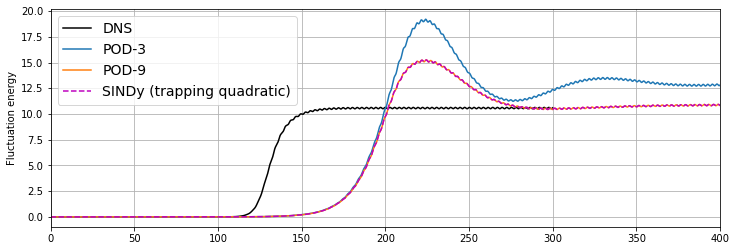

In [8]:
# Energy of the models
E = np.sum(a**2, axis=1)
E_galerkin3 = np.sum(a_galerkin3**2, axis=1)
E_galerkin9 = np.sum(a_galerkin9**2, axis=1)
E_test = np.sum(a_sindy3**2, axis=1)

plt.figure(figsize=(12, 4))
plt.plot(t, E, 'k', label='DNS')
plt.plot(t_sim, E_galerkin3, label='POD-3')
plt.plot(t_sim, E_galerkin9, label='POD-9')
plt.plot(t_sim, E_test, 'm--', label=r'SINDy (trapping quadratic)')

plt.legend(fontsize=14, loc=2)
plt.grid()
plt.xlim([0, 400])
plt.ylabel('Fluctuation energy')

In [9]:
gL = 0.5* (galerkin9['L'] + galerkin9['L'].T)
print(gL - Ls)
print(gQ - Q)
gmQ = np.tensordot(opt_m, gQ, axes=([0, 0]))

[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 

In [10]:
#print(gL, Ls)
eigvals, eigvecs = np.linalg.eig(gL)
eigvals1, eigvecs1 = np.linalg.eig(Ls)
print(np.sort(eigvals), np.sort(eigvals1))

[-0.20262021 -0.20112474 -0.06700114 -0.0611736  -0.04478155 -0.01839508
 -0.01110127  0.03172203  0.05787932] [-0.20262021 -0.20112474 -0.06700114 -0.0611736  -0.04478155 -0.01839508
 -0.01110127  0.03172203  0.05787932]


In [11]:
eigvals, eigvecs = np.linalg.eig(gL - gmQ)
eigvals1, eigvecs1 = np.linalg.eig(Ls - np.tensordot(opt_m,Q, axes=([0,0])))
print(np.sort(eigvals), np.sort(eigvals1))

[-0.38030362 -0.37191161 -0.24493238 -0.24283262 -0.17843199 -0.16555309
 -0.05314695 -0.02731931 -0.02359534] [-0.38030362 -0.37191161 -0.24493238 -0.24283262 -0.17843199 -0.16555309
 -0.05314695 -0.02731931 -0.02359534]


In [12]:
#Qsum = Q + np.transpose(Q, [2, 1, 0]) + np.transpose(Q, [1, 0, 2])
Qsum = Q + np.transpose(Q, [1, 0, 2]) + np.transpose(Q, [2, 1, 0])
print(Qsum)

[[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00  5.42101086e-20  0.00000000e+00
    0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   -5.42101086e-20  2.03287907e-20  0.00000000e+00  0.00000000e+00
   -3.03576608e-18]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   -1.73472348e-18 -6.93889390e-18  0.00000000e+00  0.00000000e+00
    0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    6.93889390e-18 -1.73472348e-18  0.00000000e+00  2.71050543e-20
    2.71050543e-20]
  [ 0.00000000e+00  0.00000000e+00 -3.46944695e-18  1.38777878e-17
    0.00000000e+00  2.16840434e-19  0.00000000e+00  0.00000000e+00
    0.00000000e+00]
  [ 0.00000000e+00  2.71050543e-20  0.00000000e+00 -3.46944695e-18
    0.00000000e+00  0.00000000e+00 -3.46944695e-18  0.00000000e+00
    0.00000000e+00]
  [ 5.42101086e-20  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.000

In [13]:
print(sindy_opt.PW_history_)

[array([-0.38030362, -0.37191161, -0.24493238, -0.24283262, -0.17843199,
       -0.16555309, -0.05314695, -0.02731931, -0.02359534])]


In [14]:
print(sindy_opt.m_history_)

[array([-0.082978  ,  0.22032449, -0.49988563, -0.19766743, -0.35324411,
       -0.40766141, -0.31373979, -0.15443927, -0.10323253]), array([ 6.36971909e-03,  1.44140965e-03,  2.50539025e-01,  1.35496902e-01,
        6.97494209e-03, -1.41386487e-03,  1.30109416e-01,  2.14040135e-01,
        5.03943932e+00])]
